In [1]:
import torch

In [2]:
from __future__ import division
from __future__ import print_function
import time
import random
import torch.optim as optim
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F

from train import train
from train import validate
from train import test
from utils import load_data
from utils import plot_loss_with_acc
from utils import accuracy
from model import GCN
# from odel import SGC
from utils import anchor_point
from utils import split_index



### set up Parameter

In [ ]:
# 超参数定义
LEARNING_RATE = 0.01
WEIGHT_DACAY = 5e-4
EPOCHS = 1500
seed = 42
patience = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### load cite data. 加载引文数据集

In [ ]:
node_dict = {}

In [ ]:
tensor_adjacency, node_feature, tensor_x, tensor_y, train_mask, val_mask, test_mask, graph, _ = load_data(dataset_str="citeseer")
kl_point_citeseer = torch.FloatTensor(anchor_point(graph, tensor_y.numpy()))
# num_nodes, input_dim = node_feature.shape

# split

## load coauthor data. 加载coauthor数据集

In [3]:
from dgl.data import CoauthorCSDataset
coauthor = CoauthorCSDataset()
csd_g = coauthor[0]
num_class = coauthor.num_classes

In [4]:
import scipy.sparse as sp
import networkx as nx
from utils import sys_normalized_adjacency
from utils import sparse_mx_to_torch_sparse_tensor
from utils import normalize
# device = "cuda" if torch.cuda.is_available() else "cpu"
nx_csd = csd_g.to_networkx()

adj = sp.coo_matrix(nx.to_numpy_matrix(nx_csd))
sys_adj = sys_normalized_adjacency(adj)
# 获取稀疏邻接矩阵
tensor_adjacency = sparse_mx_to_torch_sparse_tensor(sys_adj)

tensor_x = csd_g.ndata['feat']  # get node feature
tensor_x = torch.FloatTensor(normalize(tensor_x))
tensor_y = csd_g.ndata['label']  # get node labels
kl_point = torch.FloatTensor(anchor_point(nx_csd, tensor_y.numpy()))

In [57]:
# save
# name = "coauthor"
name = "amzazon"
torch.save(tensor_x, "data/{}_x.pt".format(name))
torch.save(tensor_y, "data/{}_y.pt".format(name))
torch.save(tensor_adjacency, "data/{}_adj.pt".format(name))
torch.save(kl_point, "data/{}_kl_point.pt".format(name))
# y = torch.load("./SAVE.pt")

### semi split

In [48]:
# set up a dictionary conserving label-index_numpy, and then randomly select 20 nodes from each class, finally concat
num_class = coauthor.num_classes
label_dic = {}
for i in range(tensor_y.max()+1):
    label_dic[i] = []
# label_dic
for j in range(len(tensor_y)):
    label_dic[int(tensor_y[j])].append(j)

In [49]:
for value in label_dic.values():
    print(len(value))

434
2107
1412
528
5005
301
483
805
2113
283


In [50]:
from random import sample
sample_list = []
for i in label_dic:
    result = sample(label_dic[i], 20)
    sample_list += result 

In [53]:
sample_list.sort()
idx_train = np.array(sample_list)
idx_train

array([   70,    76,   202,   267,   360,   439,   469,   647,   798,
         804,   817,  1021,  1029,  1157,  1180,  1291,  1338,  1418,
        1429,  1464,  1494,  1500,  1514,  1516,  1536,  1552,  1584,
        1639,  1640,  1665,  1677,  1679,  1703,  1722,  1742,  1759,
        1831,  1858,  1886,  1928,  1972,  2008,  2024,  2074,  2076,
        2086,  2097,  2105,  2117,  2185,  2186,  2188,  2217,  2256,
        2268,  2272,  2350,  2351,  2432,  2504,  2597,  2688,  2726,
        2732,  2737,  2798,  2888,  2966,  3134,  3172,  3205,  3275,
        3339,  3402,  3415,  3479,  3503,  3597,  3613,  3625,  3692,
        3753,  3874,  4161,  4165,  4174,  4227,  4250,  4448,  4458,
        4565,  4662,  4708,  4783,  4871,  4964,  5020,  5025,  5033,
        5060,  5209,  5339,  5504,  5541,  5726,  6134,  6308,  6406,
        6452,  6643,  6646,  6693,  7258,  7322,  7701,  7810,  7914,
        8302,  8416,  8606,  8619,  8655,  8688,  8695,  8714,  8754,
        8755,  9284,

In [54]:
index_total = list(range(len(tensor_y)))
val_test = set_(index_total, sample_list, how="-")
# len(val_test)
# select 500 for valitation
val_list = sample(val_test, 500)
test_ = set_(val_test, val_list, how="-")
test_list = sample(test_, 1000)

In [55]:
import numpy as np
name = "amazon"
idx_val = np.array(val_list)
idx_test = np.array(test_list)
np.savez('split_semi/semi_idx_{}'.format(name), idx_train=idx_train, idx_val=idx_val, idx_test=idx_test)

"""
load dataset
z = np.load('split_semi/semi_idx_{}.npz'.format(name))
z["idx_train"]
"""

'\nload dataset\nz = np.load(\'split_semi/semi_idx_{}.npz\'.format(name))\nz["idx_train"]\n'

In [26]:
def set_(l1, l2, how):
    """返回列表，&交，|并，差"""
    set1 = set(l1)
    set2 = set(l2)
    if how == "&":
        return(list(set1&set2))
    elif how == "|":
        return(list(set1|set2))
    elif how == "-":
        return(list(set1-set2))

### 加载amazon数据集

In [37]:
from dgl.data import AmazonCoBuyComputerDataset
amazon = AmazonCoBuyComputerDataset()
amazon_graph = amazon[0]

In [38]:
# 删除孤立点
index = range(amazon_graph.num_nodes())
degree = amazon_graph.in_degrees(index)
acnode = []
for i in range(len(degree)):
    if degree[i] == 0:
        acnode.append(i)
amazon_graph.remove_nodes(acnode)

In [39]:
import scipy.sparse as sp
import networkx as nx
from utils import sys_normalized_adjacency
from utils import sparse_mx_to_torch_sparse_tensor
from utils import normalize
nx_amazon = amazon_graph.to_networkx()
adj = sp.coo_matrix(nx.to_numpy_matrix(nx_amazon))
sys_adj = sys_normalized_adjacency(adj)
# 获取稀疏邻接矩阵
tensor_adjacency = sparse_mx_to_torch_sparse_tensor(sys_adj)
feat = amazon_graph.ndata['feat']  # get node feature
tensor_x = torch.FloatTensor(normalize(feat))
tensor_y = amazon_graph.ndata['label']  # get node labels
kl_point = torch.FloatTensor(anchor_point(nx_amazon, tensor_y.numpy()))

## full split 0.6/0.2/0.2

In [61]:
from itertools import accumulate
def split_index(num_data, frac_list=None, shuffle=False, random_state=None):
    """仿照split方法自定义训练集，验证集，测试集的划分
    Args:
        num_data: int, number of nodes
        frac_list:
        shuffle:bool, optional
        By default we perform a consecutive split of the dataset. If True,
        we will first randomly shuffle the dataset.
        random_state:None, int or array_like, optional
        Random seed used to initialize the pseudo-random number generator.
        Can be any integer between 0 and 2**32 - 1 inclusive, an array
        (or other sequence) of such integers, or None (the default).
        If seed is None, then RandomState will try to read data from /dev/urandom
        (or the Windows analogue) if available or seed from the clock otherwise.
    Returns:
    """
    if frac_list is None:
        frac_list = [0.8, 0.1, 0.1]
    frac_list = np.asarray(frac_list)
    lengths = (num_data * frac_list).astype(int)
    lengths[-1] = num_data - np.sum(lengths[:-1])
    if shuffle:
        indices = np.random.RandomState(
            seed=random_state).permutation(num_data)
    else:
        indices = np.arange(num_data)
    return [indices[offset - length:offset] for offset, length in zip(accumulate(lengths), lengths)]

### Cora

In [ ]:
import numpy as np
name = "amazon"
idx_val = np.array(val_list)
idx_test = np.array(test_list)
np.savez('split_semi/semi_idx_{}'.format(name), idx_train=idx_train, idx_val=idx_val, idx_test=idx_test)

In [59]:
tensor_adjacency, node_feature, tensor_x, tensor_y, train_mask, val_mask, test_mask, graph, _ = load_data(dataset_str="citeseer")
# kl_point_citeseer = torch.FloatTensor(anchor_point(graph, tensor_y.numpy()))

In [62]:
citeseer_list = split_index(len(tensor_y), frac_list=[0.6, 0.2, 0.2], shuffle=True, random_state=42)

In [64]:
name = "citeseer"
idx_train = citeseer_list[0]
idx_val = citeseer_list[1]
idx_test = citeseer_list[2]
np.savez('split/full_idx_{}'.format(name), idx_train=idx_train, idx_val=idx_val, idx_test=idx_test)

1996

## 比较各数据集的平均kl


In [ ]:
citeseer_a = sum(kl_point_citeseer)/len(kl_point_citeseer)
cora_a = sum(kl_point_cora)/len(kl_point_cora)
pu_a = sum(kl_point_pubmed)/len(kl_point_pubmed)
coauthor_a = sum(kl_point_coauthor)/len(kl_point_coauthor)
amazon_a = sum(kl_point_amazon)/len(kl_point_amazon)

In [ ]:
plt.hist([kl_point_citeseer.numpy(), kl_point_cora.numpy(), kl_point_pubmed.numpy(),
          kl_point_coauthor.numpy(), kl_point_amazon.numpy()],
         label=["citeseer","cora", "pubmed", "coauthor", "amazon"],
         color = ["MediumTurquoise", 'LightSeaGreen', 'DarkCyan', "Teal", "CadetBlue"],
         alpha=1, density=True)
plt.xlabel("average_ldd")
plt.ylabel("density")
#plt.hist(kl_point_cora.numpy(), label="cora", alpha=0.2, density=True)
#plt.hist(kl_point_pubmed.numpy(), label="pubmed",  alpha=0.2, density=True)
#plt.hist(kl_point_coauthor.numpy(), label="coauthor",  alpha=0.2, density=True)
#plt.hist(kl_point_amazon.numpy(), label="amazon",  alpha=0.2, density=True)
plt.legend()

In [ ]:
plt.hist([kl_point_citeseer.numpy(), kl_point_cora.numpy(), kl_point_pubmed.numpy(),
          kl_point_coauthor.numpy(), kl_point_amazon.numpy()],
         label=["citeseer","cora", "pubmed", "coauthor", "amazon"],
         stacked=True,
         alpha=1, density=True)
plt.xlabel("average_ldd")
plt.ylabel("density")
plt.legend()

In [ ]:
print(citeseer_a, cora_a, pu_a, coauthor_a, amazon_a)

# loss

In [3]:
# focal_loss
import math
from utils import penalty_smooth
def focal_loss(outputs, y_true, kl_point, w1=0.01,
               gamma=2, penalty=False, w_gap=1):
    """

    Args:
        outputs:
        y_true:
        kl_point: 训练集需要使用的节点kl，转化为tensor
        x:

    Returns:

    """
    # 准备损失函数所需数组
    probability = F.softmax(outputs, dim=1)
    log_p = torch.log(probability)
    loss = 0
    for i in range(probability.shape[0]):
        label_id = y_true[i]
        # 当w1=0,gamma=0时，该损失函数转化为交叉熵
        loss -= torch.exp(- w1 * kl_point[label_id]) * log_p[i, label_id]\
                * math.pow((1 - probability[i, label_id]), gamma)
    if penalty:
        # 下面这个函数计算比较慢
        gap = penalty_smooth(outputs, y_true)
        loss *= torch.tensor(w_gap * gap)
    return loss / int(probability.shape[0])

In [4]:
# spl
class SPLLoss(torch.nn.NLLLoss):

    def __init__(self, *args, n_samples=0, **kwargs):
        super(SPLLoss, self).__init__(*args, **kwargs)
        self.threshold = 0.1
        self.growing_factor = 1.35
        self.v = torch.zeros(n_samples).int()

    def forward(self, input, target, index):
        pr = F.log_softmax(input, dim=1)
        super_loss = F.nll_loss(pr, target, reduction="none")
        v = self.spl_loss(super_loss)
        self.v[index] = v
        return (super_loss * v).mean()

    def increase_threshold(self):
        self.threshold *= self.growing_factor

    def spl_loss(self, super_loss):
        v = super_loss < self.threshold
        return v.int()
"""
for epoch in range(10):
    for index, data, target in tqdm.tqdm(dataloader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target, index)
        loss.backward()
        optimizer.step()
    criterion.increase_threshold()
    plot(dataloader.dataset, model, criterion)
"""

'\nfor epoch in range(10):\n    for index, data, target in tqdm.tqdm(dataloader):\n        optimizer.zero_grad()\n        output = model(data)\n        loss = criterion(output, target, index)\n        loss.backward()\n        optimizer.step()\n    criterion.increase_threshold()\n    plot(dataloader.dataset, model, criterion)\n'

In [83]:
import torch.nn as nn
# from model import GCN
device = "cuda" if torch.cuda.is_available() else "cpu"


# 训练框架
def train(model, optimizer, loss_f,
          tensor_x, tensor_adjacency,
          train_mask, tensor_y, kl_point,
          alpha=None, w1=0.01, gamma=2,
          penalty=False, w_gap=1):
    model.train()
    optimizer.zero_grad()
    """
    Parameter:
    GCN: feature, adj
    
    """
    logits, _ = model(tensor_x, tensor_adjacency, alpha=alpha)
    # logits = model(tensor_x, tensor_adjacency) # 自动调用前向传播？
    # 损失函数直接在这里定义更改就可
    if loss_f == 'focal_loss':
        loss_train = focal_loss(logits[train_mask], tensor_y[train_mask].to(device),
                                kl_point[train_mask], w1=w1, gamma=gamma,
                                penalty=penalty, w_gap=w_gap)
    elif loss_f == "spl":
        criterion = SPLLoss(n_samples=len(tensor_y[train_mask]))
        loss_train = criterion(logits[train_mask], tensor_y[train_mask].to(device),
                               index=range(len(tensor_y[train_mask])))
    else:
        # nn对象不能直接调用，需要先声明定义，之后再调用
        criterion = nn.CrossEntropyLoss()
        loss_train = criterion(logits[train_mask], tensor_y[train_mask])
    acc_train = accuracy(logits[train_mask], tensor_y[train_mask].to(device))
    loss_train.backward()  # 反向传播计算参数的梯度
    optimizer.step()  # 使用优化方法进行梯度更新
    if loss_f == "spl":
        criterion.increase_threshold()
    return loss_train.item(), acc_train.item()

# 验证函数
def validate(model, loss_f,
             tensor_x, tensor_adjacency,
             val_mask, tensor_y, kl_point,
             alpha=None, w1=0.01, gamma=2,
             penalty=False, w_gap=1):
    model.eval()
    with torch.no_grad():
        # 这个特征这里的错误可他妈坑死我了
        logits, _ = model(tensor_x, tensor_adjacency, alpha=alpha)
        # logits = model(tensor_x, tensor_adjacency)
        if loss_f == 'focal_loss':
            loss_val = focal_loss(logits[val_mask], tensor_y[val_mask].to(device),
                                  kl_point[val_mask], w1=w1, gamma=gamma, 
                                  penalty=penalty, w_gap=w_gap)
        elif loss_f == "spl":
            criterion = SPLLoss(n_samples=len(tensor_y[val_mask]))
            loss_val = criterion(logits[val_mask], tensor_y[val_mask].to(device),
                                   index=range(len(tensor_y[val_mask])))
        else:
            criterion = nn.CrossEntropyLoss()
            loss_val = criterion(logits[val_mask], tensor_y[val_mask])
        acc_val = accuracy(logits[val_mask], tensor_y[val_mask].to(device))
        return loss_val.item(), acc_val.item()

# 测试函数
def test(model, best_model, tensor_x, tensor_adjacency, test_mask, tensor_y, alpha=None):
    # 使用在验证集上最好的模型进行测试
    model.load_state_dict(torch.load(best_model))
    model.eval()
    with torch.no_grad():
        logits, x_repr = model(tensor_x, tensor_adjacency, alpha=alpha)
        # logits = model(tensor_x, tensor_adjacency) # for gat
        test_mask_logits = logits[test_mask]
        predict_y = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, tensor_y[test_mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(), tensor_y[test_mask].cpu().numpy(), x_repr


## 模型训练

GCN训练最优参数：
python -u train.py --data cora --layer 64 --test
python -u train.py --data cora --layer 64 --variant --test
python -u train.py --data citeseer --layer 32 --hidden 256 --lamda 0.6 --dropout 0.7 --test
python -u train.py --data citeseer --layer 32 --hidden 256 --lamda 0.6 --dropout 0.7 --variant --test
python -u train.py --data pubmed --layer 16 --hidden 256 --lamda 0.4 --dropout 0.5 --wd1 5e-4 --test
python -u train.py --data pubmed --layer 16 --hidden 256 --lamda 0.4 --dropout 0.5 --wd1 5e-4 --variant --test

In [90]:
# load cite data
data = 'cora'
tensor_adjacency, node_feature, tensor_x, tensor_y, train_mask, val_mask, test_mask, graph, _ = load_data(dataset_str=data)
kl_point = torch.FloatTensor(anchor_point(graph, tensor_y.numpy()))
# kl_point = torch.load("data/{}_kl_point.pt".format(data))

In [93]:
graph

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

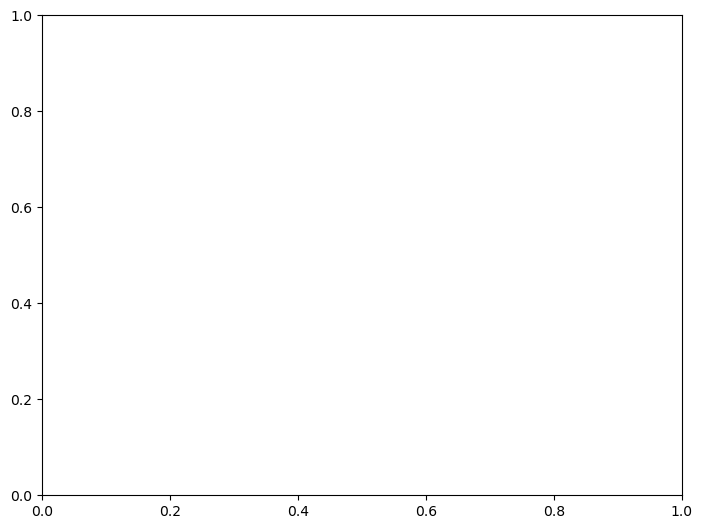

In [92]:
import networkx as nx
nx.draw(graph, node_size=150,width=0.8)    #,with_labels=True)
G = nx.from_numpy_matrix(np.matrix(adj_mtx_np), create_using=nx.DiGraph)
# nx.draw(F,with_labels=True)
plt.show()

In [87]:
from utils import sample_mask
new_idx = np.load("split/semi_new_idx_{}.npz".format(data))
idx_train = new_idx["idx_train"]
idx_test = new_idx["idx_test"]
idx_val = new_idx["idx_val"]

train_mask = torch.BoolTensor(sample_mask(idx_train, len(tensor_y)))
val_mask = torch.BoolTensor(sample_mask(idx_val, len(tensor_y)))

In [57]:
LEARNING_RATE = 0.01
WEIGHT_DACAY = 5e-4
EPOCHS = 1500
seed = 42
patience = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(seed)
nhidden = 128
dropout = 0.6
# penalty = False
model_name = 'g1015_GCNII_128_'
checkpt_file = 'pretrained/best_' + data + model_name +'.pt'

In [ ]:
# 构造抽样的测试集
from utils import sample_graph_metric
from utils import graph_smooth_metric
test_dic = sample_graph_metric(len(tensor_y))
graph_smooth_metric(test_dic, x_repr[-1])

## 原GCN

In [54]:
from model import GCN
from model import GAT
from model import APPNP
from model import GCNII
from model import JKNet

In [81]:
w1 = 0.01
gamma = 2
a = 0.1
#lamda = 0.5 
dropout = 0.6
nhidden = 128

In [ ]:
GCN
model = GCN(nfeat=tensor_x.shape[1], nclass=int(tensor_y.max()) + 1,
            nlayers=nlayer, nhidden=nhidden, dropout=dropout).to(device)
        
GAT
model = GAT(nfeat=tensor_x.shape[1], nhid=nhidden, nclass=int(tensor_y.max()) + 1,
            dropout=dropout, alpha=0.2, nheads=nlayer).to(device)

APPNP
model = APPNP(nfeat=tensor_x.shape[1], nclass=int(tensor_y.max()) + 1,
            nlayers=nlayer, nhidden=nhidden, dropout=dropout).to(device)
            
GCNII
model = GCNII(nfeat=tensor_x.shape[1], nlayers=nlayer,
              nhidden=nhidden, nclass=int(tensor_y.max()) + 1,
              dropout=dropout, lamda=lamda, alpha=a, variant=False).to(device)

JKNet
model = JKNet(nfeat=tensor_x.shape[1], nhid=nhidden, nclass=int(tensor_y.max()) + 1,
        model = JKNet(in_dim=tensor_x.shape[1], hid_dim=nhidden, out_dim=int(tensor_y.max()) + 1,
                      num_layers=nlayer, mode="lstm", dropout=dropout).to(device)

In [84]:
a = 0.5

In [89]:
for nlayer in [2, 4, 6, 8, 16, 32, 64]:
#for nlayer in [3]:
    for loss in ["nll_loss", "focal_loss"]:
        if loss == "focal_loss":
            penalty = True
        else:
            penalty = False
        loss_history = []
        acc_history = []
        t_total = time.time()
        bad_counter = 0
        # best = 999999999
        best = 0
        # best_epoch = 0
        acc = 0
        # initacial
        model = APPNP(nfeat=tensor_x.shape[1], nclass=int(tensor_y.max()) + 1,
                      nlayers=nlayer, nhidden=nhidden, dropout=dropout).to(device)
        optimizer = optim.Adam(model.parameters(),
                               lr=LEARNING_RATE,
                               weight_decay=WEIGHT_DACAY)
        for epoch in range(EPOCHS):
            train_loss, train_acc = train(model, optimizer, loss, tensor_x, tensor_adjacency,
                                          train_mask, tensor_y, kl_point, alpha=a, w1=w1,
                                          gamma=gamma, penalty=penalty, w_gap=1)  # 计算当前模型训练集上的准确率
            val_loss, val_acc = validate(model, loss, tensor_x, tensor_adjacency,
                                         val_mask, tensor_y, kl_point, alpha=a, w1=w1,
                                         gamma=gamma, penalty=penalty, w_gap=1)  # 计算当前模型在验证集上的准确率
            # 记录训练过程中损失值和准确率的变化，用于画图

            loss_history.append((train_loss, val_loss))
            acc_history.append((train_acc, val_acc))

            if (epoch + 1) % 1 == 0:
                print('Epoch:{:04d}'.format(epoch + 1),
                      'train',
                      'loss:{:.3f}'.format(train_loss),
                      'acc:{:.4f}'.format(train_acc * 100),
                      '| val',
                      'loss:{:.3f}'.format(val_loss),
                      'acc:{:.4f}'.format(val_acc * 100))
            if val_acc > best:
                best = val_acc
                # best_epoch = epoch
                # acc = val_acc
                torch.save(model.state_dict(), checkpt_file)
                bad_counter = 0
            else:
                bad_counter += 1
            if bad_counter == patience:
                break

        best_model = checkpt_file
        test_acc, test_logits, test_label, x_repr = test(model, best_model, tensor_x, tensor_adjacency, test_mask, tensor_y, alpha=a)
        #_, corrcoef = graph_smooth_metric(test_dic, x_repr[-1])
        print("Test accuarcy: ", test_acc.item())
        with open('/Users/MC/Desktop/research/GraphNeuralNetwork-master/chapter5/final_log.txt', 'a+') as f:
            print('RESULT:------data:{}, layer:{}, hidden:{}, loss: {}------'
                  .format(data, nlayer, nhidden, loss), file=f)
            print("Test accuarcy:{}".format(test_acc.item()), file=f)


Epoch:0001 train loss:1.110 acc:25.0000 | val loss:1.073 acc:41.2000
Epoch:0002 train loss:1.080 acc:38.3333 | val loss:1.043 acc:41.2000
Epoch:0003 train loss:1.055 acc:49.1667 | val loss:1.016 acc:56.4000
Epoch:0004 train loss:1.006 acc:55.8333 | val loss:0.977 acc:59.6000
Epoch:0005 train loss:0.918 acc:70.0000 | val loss:0.919 acc:73.4000
Epoch:0006 train loss:0.831 acc:85.0000 | val loss:0.824 acc:73.8000
Epoch:0007 train loss:0.662 acc:90.0000 | val loss:0.715 acc:74.2000
Epoch:0008 train loss:0.471 acc:93.3333 | val loss:0.654 acc:73.2000
Epoch:0009 train loss:0.329 acc:93.3333 | val loss:0.617 acc:74.6000
Epoch:0010 train loss:0.209 acc:95.0000 | val loss:0.644 acc:74.0000
Epoch:0011 train loss:0.125 acc:96.6667 | val loss:0.751 acc:75.8000
Epoch:0012 train loss:0.063 acc:99.1667 | val loss:0.830 acc:76.0000
Epoch:0013 train loss:0.036 acc:99.1667 | val loss:0.930 acc:77.8000
Epoch:0014 train loss:0.016 acc:100.0000 | val loss:1.094 acc:77.4000
Epoch:0015 train loss:0.002 acc:1

/var/folders/ck/vf0jxkkx5kq60sh06l46fxym0000gn/T/ipykernel_9330/890761032.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss *= torch.tensor(w_gap * gap)


Epoch:0001 train loss:12.873 acc:32.5000 | val loss:2.777 acc:41.2000
Epoch:0002 train loss:7.638 acc:40.0000 | val loss:2.660 acc:41.2000
Epoch:0003 train loss:6.390 acc:49.1667 | val loss:4.531 acc:66.4000
Epoch:0004 train loss:5.864 acc:65.0000 | val loss:4.148 acc:71.2000
Epoch:0005 train loss:5.029 acc:70.0000 | val loss:3.742 acc:67.8000
Epoch:0006 train loss:3.732 acc:73.3333 | val loss:3.331 acc:71.2000
Epoch:0007 train loss:2.651 acc:80.8333 | val loss:2.888 acc:74.2000
Epoch:0008 train loss:0.401 acc:90.0000 | val loss:0.960 acc:73.8000
Epoch:0009 train loss:0.282 acc:91.6667 | val loss:1.021 acc:73.4000
Epoch:0010 train loss:0.239 acc:94.1667 | val loss:1.098 acc:72.6000
Epoch:0011 train loss:0.840 acc:92.5000 | val loss:1.260 acc:74.8000
Epoch:0012 train loss:0.092 acc:95.8333 | val loss:4.710 acc:75.4000
Epoch:0013 train loss:0.110 acc:93.3333 | val loss:5.692 acc:76.2000
Epoch:0014 train loss:0.100 acc:95.8333 | val loss:6.426 acc:76.6000
Epoch:0015 train loss:0.059 acc:9

Epoch:0012 train loss:0.819 acc:85.0000 | val loss:5.483 acc:75.0000
Epoch:0013 train loss:0.074 acc:94.1667 | val loss:1.728 acc:70.4000
Epoch:0014 train loss:0.156 acc:90.8333 | val loss:1.652 acc:67.4000
Epoch:0015 train loss:0.203 acc:90.0000 | val loss:1.669 acc:70.2000
Epoch:0016 train loss:0.180 acc:90.8333 | val loss:1.236 acc:74.6000
Epoch:0017 train loss:0.045 acc:96.6667 | val loss:0.933 acc:78.6000
Epoch:0018 train loss:0.008 acc:100.0000 | val loss:0.857 acc:76.4000
Epoch:0019 train loss:0.006 acc:99.1667 | val loss:0.905 acc:76.2000
Epoch:0020 train loss:0.012 acc:97.5000 | val loss:0.944 acc:74.6000
Epoch:0021 train loss:0.036 acc:95.8333 | val loss:0.981 acc:73.4000
Epoch:0022 train loss:0.033 acc:96.6667 | val loss:0.971 acc:75.0000
Epoch:0023 train loss:0.008 acc:98.3333 | val loss:0.963 acc:76.0000
Epoch:0024 train loss:0.001 acc:100.0000 | val loss:0.994 acc:76.6000
Epoch:0025 train loss:0.007 acc:99.1667 | val loss:1.036 acc:77.8000
Epoch:0026 train loss:0.004 acc:

Epoch:0018 train loss:0.878 acc:42.5000 | val loss:0.943 acc:55.6000
Epoch:0019 train loss:0.346 acc:66.6667 | val loss:0.507 acc:72.8000
Epoch:0020 train loss:0.088 acc:92.5000 | val loss:6.413 acc:64.0000
Epoch:0021 train loss:0.325 acc:85.0000 | val loss:1.062 acc:66.0000
Epoch:0022 train loss:0.213 acc:85.0000 | val loss:0.629 acc:71.8000
Epoch:0023 train loss:0.077 acc:89.1667 | val loss:0.810 acc:72.0000
Epoch:0024 train loss:0.126 acc:90.8333 | val loss:1.310 acc:70.6000
Epoch:0025 train loss:0.214 acc:88.3333 | val loss:5.241 acc:70.2000
Epoch:0026 train loss:0.243 acc:88.3333 | val loss:5.038 acc:69.2000
Epoch:0027 train loss:0.346 acc:86.6667 | val loss:1.081 acc:70.2000
Epoch:0028 train loss:0.143 acc:90.8333 | val loss:1.018 acc:64.8000
Epoch:0029 train loss:0.188 acc:87.5000 | val loss:0.786 acc:69.0000
Epoch:0030 train loss:0.092 acc:92.5000 | val loss:0.489 acc:73.6000
Epoch:0031 train loss:0.055 acc:97.5000 | val loss:0.418 acc:70.4000
Epoch:0032 train loss:0.055 acc:94

Epoch:0010 train loss:0.466 acc:79.1667 | val loss:0.703 acc:52.6000
Epoch:0011 train loss:0.414 acc:60.8333 | val loss:0.566 acc:55.2000
Epoch:0012 train loss:0.293 acc:60.8333 | val loss:0.478 acc:60.4000
Epoch:0013 train loss:0.257 acc:68.3333 | val loss:0.416 acc:60.2000
Epoch:0014 train loss:0.284 acc:70.0000 | val loss:0.467 acc:57.2000
Epoch:0015 train loss:0.387 acc:72.5000 | val loss:0.504 acc:65.8000
Epoch:0016 train loss:0.247 acc:83.3333 | val loss:3.421 acc:70.2000
Epoch:0017 train loss:0.405 acc:85.0000 | val loss:2.822 acc:74.8000
Epoch:0018 train loss:0.230 acc:92.5000 | val loss:0.539 acc:73.4000
Epoch:0019 train loss:0.186 acc:89.1667 | val loss:0.474 acc:74.6000
Epoch:0020 train loss:0.099 acc:94.1667 | val loss:3.214 acc:75.8000
Epoch:0021 train loss:0.104 acc:93.3333 | val loss:0.749 acc:75.8000
Epoch:0022 train loss:0.102 acc:92.5000 | val loss:0.448 acc:73.8000
Epoch:0023 train loss:0.058 acc:94.1667 | val loss:0.446 acc:72.4000
Epoch:0024 train loss:0.151 acc:89

Epoch:0050 train loss:0.007 acc:100.0000 | val loss:1.181 acc:78.6000
Epoch:0051 train loss:0.005 acc:100.0000 | val loss:1.155 acc:80.0000
Epoch:0052 train loss:0.002 acc:100.0000 | val loss:1.313 acc:81.2000
Epoch:0053 train loss:0.022 acc:99.1667 | val loss:0.856 acc:77.0000
Epoch:0054 train loss:0.072 acc:96.6667 | val loss:1.608 acc:73.0000
Epoch:0055 train loss:0.033 acc:100.0000 | val loss:1.650 acc:71.0000
Epoch:0056 train loss:0.120 acc:96.6667 | val loss:1.105 acc:77.6000
Epoch:0057 train loss:0.010 acc:100.0000 | val loss:1.182 acc:79.0000
Epoch:0058 train loss:0.038 acc:99.1667 | val loss:1.200 acc:78.4000
Epoch:0059 train loss:0.021 acc:99.1667 | val loss:0.987 acc:79.6000
Epoch:0060 train loss:0.010 acc:100.0000 | val loss:0.794 acc:82.4000
Epoch:0061 train loss:0.005 acc:100.0000 | val loss:0.731 acc:82.8000
Epoch:0062 train loss:0.008 acc:100.0000 | val loss:0.722 acc:82.4000
Epoch:0063 train loss:0.011 acc:100.0000 | val loss:1.217 acc:74.2000
Epoch:0064 train loss:0.0

Epoch:0057 train loss:0.001 acc:100.0000 | val loss:1.199 acc:81.8000
Epoch:0058 train loss:0.003 acc:100.0000 | val loss:1.170 acc:82.0000
Epoch:0059 train loss:0.002 acc:100.0000 | val loss:1.146 acc:82.4000
Epoch:0060 train loss:0.002 acc:100.0000 | val loss:1.125 acc:82.4000
Epoch:0061 train loss:0.001 acc:100.0000 | val loss:1.107 acc:81.8000
Epoch:0062 train loss:0.002 acc:100.0000 | val loss:1.092 acc:81.2000
Epoch:0063 train loss:0.003 acc:100.0000 | val loss:1.076 acc:81.0000
Epoch:0064 train loss:0.003 acc:100.0000 | val loss:1.062 acc:81.4000
Epoch:0065 train loss:0.002 acc:100.0000 | val loss:1.044 acc:81.0000
Epoch:0066 train loss:0.005 acc:100.0000 | val loss:1.009 acc:81.0000
Epoch:0067 train loss:0.003 acc:100.0000 | val loss:0.976 acc:81.4000
Epoch:0068 train loss:0.002 acc:100.0000 | val loss:0.948 acc:82.0000
Epoch:0069 train loss:0.006 acc:100.0000 | val loss:0.921 acc:82.4000
Epoch:0070 train loss:0.003 acc:100.0000 | val loss:0.900 acc:82.6000
Epoch:0071 train los

Epoch:0020 train loss:0.250 acc:90.8333 | val loss:0.956 acc:75.6000
Epoch:0021 train loss:0.116 acc:97.5000 | val loss:0.936 acc:77.4000
Epoch:0022 train loss:0.093 acc:97.5000 | val loss:1.000 acc:78.2000
Epoch:0023 train loss:0.106 acc:95.8333 | val loss:0.883 acc:80.6000
Epoch:0024 train loss:0.037 acc:100.0000 | val loss:0.890 acc:80.2000
Epoch:0025 train loss:0.017 acc:100.0000 | val loss:0.955 acc:78.8000
Epoch:0026 train loss:0.015 acc:100.0000 | val loss:1.018 acc:78.0000
Epoch:0027 train loss:0.017 acc:100.0000 | val loss:1.043 acc:78.2000
Epoch:0028 train loss:0.011 acc:100.0000 | val loss:1.053 acc:79.0000
Epoch:0029 train loss:0.010 acc:100.0000 | val loss:1.060 acc:80.2000
Epoch:0030 train loss:0.021 acc:99.1667 | val loss:1.114 acc:80.0000
Epoch:0031 train loss:0.008 acc:100.0000 | val loss:1.187 acc:80.2000
Epoch:0032 train loss:0.003 acc:100.0000 | val loss:1.265 acc:80.0000
Epoch:0033 train loss:0.002 acc:100.0000 | val loss:1.332 acc:79.8000
Epoch:0034 train loss:0.0

In [ ]:

for i in x_repr:
    _, corrcoef = graph_smooth_metric(test_dic, i)
    print(corrcoef)

In [ ]:
plot_loss_with_acc(loss_history, acc_history)
#plt.savefig('pic/gcnii_64_64_focal.jpg')

In [ ]:
plot_loss_with_acc(loss_history, acc_history)

# a simple test

In [ ]:
gg = nx.Graph()

In [ ]:
nodes_ = list(range(10))
gg.add_nodes_from(nodes_)
edges_ = [(0, 1), (0, 2), (0, 3), (0, 4), (5, 6), (5, 7), (5, 8), (5, 9), (0, 5)]
gg.add_edges_from(edges_)

In [ ]:
# subax1 = plt.subplot(121)
nx.draw(gg, with_labels=True, font_weight='bold')

In [ ]:
adj_gg = np.array(nx.to_numpy_matrix(gg))
# adj_gg
x = np.eye(10, 10)
y = np.array([0]*5 +[1]*5)

In [ ]:
idx_1 = [0, 1, 2, 3, 5, 6, 7, 8]
idx_2 = [4, 9]

In [ ]:
# 全部转化为tensor
from utils import sparse_mx_to_torch_sparse_tensor
from utils import sys_normalized_adjacency
adj_tensor = sparse_mx_to_torch_sparse_tensor(sys_normalized_adjacency(adj_gg))
x_tensor = torch.FloatTensor(x)
y_tensor = torch.LongTensor(y)
t_mask = torch.BoolTensor(sample_mask(idx_1, len(y)))
v_mask = torch.BoolTensor(sample_mask(idx_2, len(y)))
e_mask = torch.BoolTensor(sample_mask(list(range(10)), len(y)))

In [ ]:
#from Model import GCNI
# for nlayers in [4, 8, 16, 32, 64]:
data = "test"
for nlayers in [16]:
    for loss in ["nll_loss"]:
        loss_history = []
        acc_history = []
        t_total = time.time()
        bad_counter = 0
        # best = 999999999
        best = 0
        # best_epoch = 0
        acc = 0
        # 模型定义：Model, Loss, Optimizer
        
        model = GCNI(nfeat=x_tensor.shape[1], nclass=int(y_tensor.max()) + 1, nlayers=nlayers, nhidden=nhidden,dropout=dropout).to(device)
        optimizer = optim.Adam(model.parameters(),
                               lr=LEARNING_RATE,
                               weight_decay=WEIGHT_DACAY)

        for epoch in range(EPOCHS):
            
            # 记录训练过程中损失值和准确率的变化，用于画图
            train_loss, train_acc = train_GCNII(model, optimizer, x_tensor, adj_tensor,
                                          t_mask, y_tensor, loss)  # 计算当前模型训练集上的准确率
            val_loss, val_acc = val_GCNII(model, x_tensor, adj_tensor,
                                         v_mask, y_tensor, loss)  # 计算当前模型在验证集上的准确率
            loss_history.append((train_loss, val_loss))
            acc_history.append((train_acc, val_acc))

            if (epoch + 1) % 1 == 0:
                print('Epoch:{:04d}'.format(epoch + 1),
                      'train',
                      'loss:{:.3f}'.format(train_loss),
                      'acc:{:.4f}'.format(train_acc * 100),
                      '| val',
                      'loss:{:.3f}'.format(val_loss),
                      'acc:{:.4f}'.format(val_acc * 100))
            if val_acc > best:
                best = val_acc
                # best_epoch = epoch
                # acc = val_acc
                torch.save(model.state_dict(), checkpt_file)
                bad_counter = 0
            else:
                bad_counter += 1
            if bad_counter == patience:
                break
best_model = checkpt_file
test_acc, test_logits, test_label, x_repr = test_GCNII(model, best_model, x_tensor, adj_tensor, e_mask, y_tensor)


In [ ]:
# from utils import avg_abs
def avg_abs(matrix):
    """
    Args:
        matrix:

    Returns:各节点的平均相关系数

    """
    a = matrix.shape[0]
    b = matrix.shape[1]
    ss = np.zeros(a)
    for i in range(a):
        s = 0
        for j in range(b):
            s += abs(matrix[i][j])
        ss[i] = (s - 1) / (a - 1)
    return ss

def GSI(node_embedding):
    cor_matrix = np.corrcoef(node_embedding)
    avg_cor_list = avg_abs(cor_matrix)
    corrcoef = sum(avg_cor_list) / len(avg_cor_list)
    return corrcoef

In [ ]:
for i in x_repr:
    corrcoef = GSI(i.numpy())
    print(corrcoef)

In [ ]:
x_repr

## kl指数与准确率之间的关系

In [ ]:
def build_result_df(kl_point, label, logits, idy, pic_name, is_plot=False):
    """建立关于节点标签，预测值与kl值的数据框，方便进行数据分析
    Args:
        graph:nx中的graph对象
        label:
        logits:最后的输出
        idy:用来计算的节点的index
        pic_name:将图片进行存储的名称

    Returns: dataframe（方便进行数据分析）
    """
    # 转array数组
    test_y = label[idy].numpy()  # 标签
    prediction = logits.max(1)[1]
    predict_y = prediction.numpy()  # 预测值
    result_array = np.vstack((test_y, predict_y))  # 垂直堆积数组

    result_df = pd.DataFrame(result_array)
    result_df = result_df.T
    result_df = result_df.rename(columns={0: "label", 1: "prediction"})
    # 增加kl指数列
    point = kl_point[idy]
    result_df['kl_point'] = point
    # 增加准确率列
    result_df['acc'] = result_df.apply(lambda x: 1 if x.label == x.prediction else 0, axis=1)
    # 将kl值分箱离散处理
    bins = [0, 1e-5, 5, 10, 15, 20, 25, 30, 40]
    labels = [(bins[i], bins[i + 1]) for i in range(len(bins) - 1)]
    result_df['interval'] = pd.cut(x=result_df['kl_point'], bins=bins, labels=labels, right=False, include_lowest=True)
    if is_plot:
        acc_dis = result_df.groupby(['interval'])['acc'].mean()
        acc = ['{}'.format(i) for i in acc_dis.index]
        plt.figure(figsize=(10, 5))
        plt.bar(acc, list(acc_dis.values), color='#2F4F4F')
        plt.xlabel('CDS', size=13)
        plt.ylabel('accuracy', size=13)
        plt.savefig('pic/{}.jpg'.format(pic_name))
    return result_df

In [ ]:
import pandas as pd
df = build_result_df(kl_point, tensor_y, test_logits, idy=test_mask, pic_name="**.jpg", is_plot=True)

In [ ]:
from utils import avg_abs
def graph_smooth_metric(dic, node_embedding):
    """
    计算全图的相关系数
    Args:
        dic: 存储多次放回抽样的样本
        node_embedding: 所有节点表示

    Returns:

    """
    # node_embedding = node_embedding.numpy()
    # 记录样本均值
    corrcoef = []
    for i in range(len(dic)):
        sample = dic[i]
        use_embedding = node_embedding[sample]
        # 抽样节点的相关系数矩阵
        cor_matrix = np.corrcoef(use_embedding)
        avg_cor_list = avg_abs(cor_matrix)
        corrcoef.append(sum(avg_cor_list) / len(avg_cor_list))
        # abs_matrix = np.maximum(x, -x), 取绝对值运算
    return corrcoef, sum(corrcoef) / len(corrcoef)

In [ ]:
import seaborn as sns
plt.style.use('ggplot')
sns.lineplot(lay_l, result_1, label='all', linestyle='--')
sns.lineplot(lay_l, result_30, label='sample_30')
sns.lineplot(lay_l, result_50, label='sample_50')
sns.lineplot(lay_l, result_100, label='sample_100')
sns.lineplot(lay_l, result_150, label='sample_150')
sns.lineplot(lay_l, result_200, label='sample_200')
plt.xlabel('layer')
plt.ylabel("GSI")
plt.legend()

In [ ]:
#lay_l = [0, 2, 4, 6, 8, 10, 12, 14, 16]
#plt.plot(lay_l, result_1, label='new_focal_loss')
plt.plot(lay_l, result_2, label='cross_loss')
plt.xlabel('layer')
plt.ylabel("smooth_point")
plt.legend()
#plt.savefig("pic/gcnii_32_cp.jpg")

In [ ]:
print(result_1, result_2)

[0.602859555520298, 0.9566081323551006, 0.9844643359084218, 0.9907878088419304, 0.9922291004721646, 0.9949655117537931, 0.9946713176155001, 0.9941030748387849, 0.9944954783924311]

[0.3108020890582047, 0.8576967839466505, 0.9422434068356622, 0.9719488794943217, 0.9887902997788125, 0.9931819256177867, 0.9948218507600602, 0.996486339799523, 0.9964306877167679]

[0.42299069500722747, 0.5165361688924619, 0.529959208265846, 0.5198351359427967, 0.5163483046298408, 0.5164835281020107, 0.516444828882187, 0.5164367938621377, 0.5188479606399918]

[0.3395749384658731, 0.43567608963945287, 0.45004840274331687, 0.43373123438413097, 0.42559468333665434, 0.4190755935974977, 0.41374638790468027, 0.41146850683486785, 0.4110902065272529]

# 实验结果记录
0-16：80.70%，
0-64：81.4%
1-64：81.60%-81.70%

0-128:81.70%
0.813400000333786
（0.8149999976158142，0.8100000023841858）

2-64:80.8%
4-64:76.8%
8-64:53.4%

1-128:84.40% /83.0%,这种情况下好不稳定。
82.2%
(0.8389999866485596 0.8019999861717224)